In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_hub as tfhub
import tensorflow_datasets as tfds

### Load Data

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes


### Create TensorFlow Dataset

In [3]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

### Build Model
[TF HUB](https://tfhub.dev/) <br>
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

In [4]:
model = tf.keras.Sequential([
    tfhub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.build([None, 224, 224, 3])
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 6
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 52s 77ms/step - loss: 0.0474 - accuracy: 0.9828 - val_loss: 0.0387 - val_accuracy: 0.9871
Epoch 2/6
582/582 [==============================] - 46s 77ms/step - loss: 0.0282 - accuracy: 0.9903 - val_loss: 0.0463 - val_accuracy: 0.9858
Epoch 3/6
582/582 [==============================] - 46s 78ms/step - loss: 0.0209 - accuracy: 0.9924 - val_loss: 0.0505 - val_accuracy: 0.9854
Epoch 4/6
582/582 [==============================] - 46s 78ms/step - loss: 0.0174 - accuracy: 0.9944 - val_loss: 0.0497 - val_accuracy: 0.9875
Epoch 5/6
582/582 [==============================] - 46s 78ms/step - loss: 0.0152 - accuracy: 0.9946 - val_loss: 0.0456 - val_accuracy: 0.9880
Epoch 6/6
582/582 [==============================] - 45s 76ms/step - loss: 0.0145 - accuracy: 0.9949 - val_loss: 0.0576 - val_accuracy: 0.9858


### Option A: Save model --> Read and Convert TF Lite Model --> Save TF Lite Model

In [5]:
# Save Your Model
tf.saved_model.save(model,export_dir='model_dir/post_training_demo/')


# Setup Converter and read TF model directory
converter = tf.lite.TFLiteConverter.from_saved_model('model_dir/post_training_demo/')

##################
# OPTIMIZATIONS ##
###################
"""
Options:

OPTIMIZE_FOR_SIZE Deprecated. Does the same as DEFAULT.
OPTIMIZE_FOR_LATENCY Deprecated. Does the same as DEFAULT.
EXPERIMENTAL_SPARSITY Experimental flag, subject to change.
"""
# Find balance Between Size and Latency
converter.optimizations = [tf.lite.Optimize.DEFAULT] 

"""
Full Integer Quantization or float16 Quantization
"""
# converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


"""
In order to quantize your model weights, 
you will need to give a sample dataset for calculations to infer the min max values 
"""
def representative_data_generataor(num=100):
    # allows concverter to inspect data and make optimizations selections (where to best make conversions)
    for image, _ in test_batches.take(num):
        yield [image]

converter.representative_dataset = representative_data_generataor

tflite_model = converter.convert()

with open('model_dir/post_training_demo/CATS_DOGS_CLF2.tflite','wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: model_dir/post_training_demo/assets


INFO:tensorflow:Assets written to: model_dir/post_training_demo/assets


### Option B: Direct Conversion of Keras Model to TF Lite Model (Only Possible if full model is built by tf.keras)

In [6]:
#####################################################################################
# Setup Converter and read TF model directory
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#####################################################################################


##################
# OPTIMIZATIONS ##
###################
"""
Options:

OPTIMIZE_FOR_SIZE Deprecated. Does the same as DEFAULT.
OPTIMIZE_FOR_LATENCY Deprecated. Does the same as DEFAULT.
EXPERIMENTAL_SPARSITY Experimental flag, subject to change.
"""
# Find balance Between Size and Latency
converter.optimizations = [tf.lite.Optimize.DEFAULT] 

"""
Full Integer Quantization or float16 Quantization
"""
# converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]


"""
In order to quantize your model weights, 
you will need to give a sample dataset for calculations to infer the min max values 
"""
def representative_data_generataor(num=200):
    # allows concverter to inspect data and make optimizations selections (where to best make conversions)
    for image, _ in test_batches.take(num):
        yield [image]

converter.representative_dataset = representative_data_generataor

tflite_model = converter.convert()

with open('model_dir/post_training_demo/CATS_DOGS_CLF_Keras.tflite','wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpon4a1y05\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpon4a1y05\assets


## 

## Inferencing with TFLite Models Using Python Interpreter 

In [7]:
model = tf.lite.Interpreter(model_path = 'model_dir/post_training_demo/CATS_DOGS_CLF_Keras.tflite'
                            ,num_threads=16)
model.allocate_tensors()

In [8]:
model.get_input_details()

[{'name': 'serving_default_keras_layer_input:0',
  'index': 0,
  'shape': array([  1, 224, 224,   3]),
  'shape_signature': array([ -1, 224, 224,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [9]:
model.get_input_details()

[{'name': 'serving_default_keras_layer_input:0',
  'index': 0,
  'shape': array([  1, 224, 224,   3]),
  'shape_signature': array([ -1, 224, 224,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [10]:
predictions = []
test_labels = [] 
test_imgs =  []

input_index = model.get_input_details()[0]["index"]
output_index = model.get_output_details()[0]["index"]

test_batches = raw_test.map(format_image).batch(1) 
# Change BATCH_SIZE to 1 due to the require shape displayed above

for img, label in test_batches.take(200):
    # Step 1 set tensor
    model.set_tensor(input_index, img)
    
    # Step 2 Run Inference
    model.invoke()
    pred = model.get_tensor(output_index)
    ##
    
    predictions.append(pred)
    test_labels.append(label.numpy()[0])

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,accuracy_score

In [12]:
np_preds = []
for res in predictions:
    res = np.argmax(res,axis=1)
    np_preds.append(res)

In [13]:
cm = confusion_matrix(test_labels,np_preds)
acc = accuracy_score(test_labels,np_preds)

In [14]:
print(f"Accuracy Score out of 200 samples: {acc * 100} %")

Accuracy Score out of 200 samples: 98.5 %


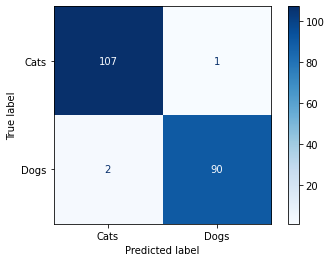

In [15]:
cm_plot = ConfusionMatrixDisplay(cm,display_labels=['Cats','Dogs'])
res = cm_plot.plot(cmap='Blues')